In [1]:
import sys

import numpy as np
from scipy import special, stats

import matplotlib.pyplot as plt

In [2]:
n_true = 60
x_true = 45
n_minus_x_true = n_true - x_true
binom_coeff_true = special.binom(n_true, x_true)

MCMC_theta_start = np.array([0.2, 0.9])
MCMC_num_itr_mix    = 100000
MCMC_num_itr_sample = 100000

In [3]:
def calculate_p_prime (theta) :
    theta1, theta2 = theta[0], theta[1]
    return (1. - theta1)*(1. - theta2) + theta1*theta2

def likelihood_unnormalised (theta) :
    p_prime = calculate_p_prime (theta)
    return binom_coeff_true * np.power(p_prime, x_true) * np.power(1.-p_prime, n_minus_x_true)

def sample_theta1_given_theta2 (theta2, n_samples=1, ndiv=10) :
    cdf_x = np.linspace(0, 1, ndiv+1)
    pdf_y = likelihood_unnormalised([cdf_x, theta2])
    pdf_y = 0.5 * (pdf_y[1:] + pdf_y[:-1])
    cdf_y = np.concatenate([[0], [np.sum(pdf_y[:i+1]) for i in range(ndiv)]])
    cdf_y = cdf_y / cdf_y[-1]
    return np.interp(np.random.rand(n_samples), cdf_y, cdf_x)

def sample_theta2_given_theta1 (theta1, n_samples=1, ndiv=10) :
    cdf_x = np.linspace(0, 1, ndiv+1)
    pdf_y = likelihood_unnormalised([theta1, cdf_x])
    pdf_y = 0.5 * (pdf_y[1:] + pdf_y[:-1])
    cdf_y = np.concatenate([[0], [np.sum(pdf_y[:i+1]) for i in range(ndiv)]])
    cdf_y = cdf_y / cdf_y[-1]
    return np.interp(np.random.rand(n_samples), cdf_y, cdf_x)

def gibbs_sample (theta_prev, ndiv=10) :
    theta1_prev, theta2_prev = theta_prev[0], theta_prev[1]
    theta1 = sample_theta1_given_theta2(theta2_prev, n_samples=1, ndiv=ndiv)[0]
    theta2 = sample_theta2_given_theta1(theta1     , n_samples=1, ndiv=ndiv)[0]
    return [theta1, theta2]

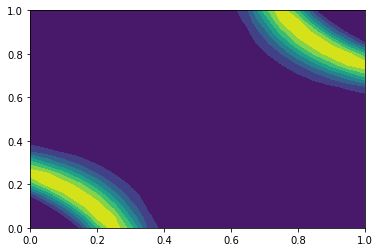

In [4]:
theta1_axis, theta2_axis = np.linspace(0, 1, 21), np.linspace(0, 1, 21)
theta1_grid, theta2_grid = np.meshgrid(theta1_axis, theta2_axis, indexing="xy")

L_grid = np.zeros(shape=theta1_grid.shape)
for i, theta1 in enumerate(theta1_axis) :
    for j, theta2 in enumerate(theta2_axis) :
        L_grid[i, j] = likelihood_unnormalised([theta1, theta2])
        
plt.contourf(theta1_grid, theta2_grid, L_grid)
plt.show()

In [5]:
theta_N_mix    = [MCMC_theta_start]
theta_N_sample = []

theta_itr = MCMC_theta_start
num_itr   = MCMC_num_itr_mix + MCMC_num_itr_sample
for i in range(num_itr) :
    if (i == 0) or ((i+1) % 1000 == 0) :
        sys.stdout.write(f"\rSample number {i+1} of {num_itr}".ljust(50))
    theta_itr = gibbs_sample(theta_itr)
    if i < MCMC_num_itr_mix :
        theta_N_mix.append(theta_itr)
        continue
    theta_N_sample.append(theta_itr)
sys.stdout.write(f"\rSampling complete".ljust(50))

theta_N_mix, theta_N_sample = np.array(theta_N_mix), np.array(theta_N_sample)

Sampling complete                                

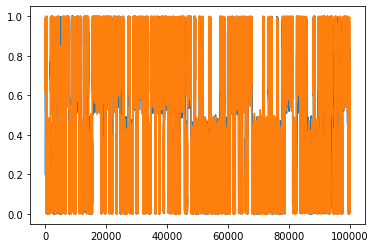

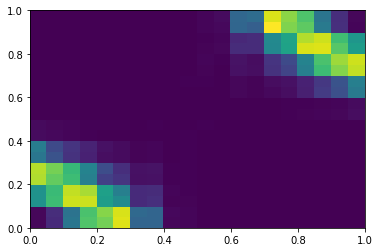

In [6]:
plt.plot(theta_N_mix[:,0])
plt.plot(theta_N_mix[:,1])
plt.show()

plt.hist2d(theta_N_sample[:,0], theta_N_sample[:,1], bins=(np.linspace(0, 1, 21), np.linspace(0, 1, 21)))
plt.show()

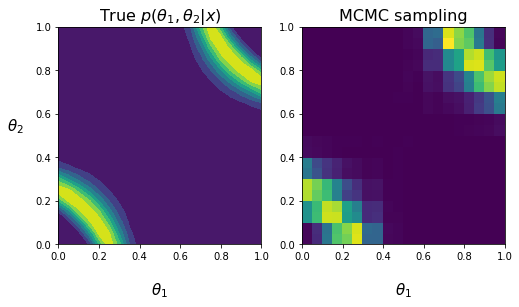

In [7]:
fig = plt.figure(figsize=(8, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.contourf(theta1_grid, theta2_grid, L_grid)
ax1.set_title(r"True $p(\theta_1, \theta_2|x)$", fontsize=16)
ax1.set_xlabel(r"$\theta_1$", fontsize=15, labelpad=20)
ax1.set_ylabel(r"$\theta_2$", rotation=0, fontsize=15, labelpad=20)

ax2 = fig.add_subplot(1, 2, 2)
ax2.hist2d(theta_N_sample[:,0], theta_N_sample[:,1], bins=(np.linspace(0, 1, 21), np.linspace(0, 1, 21)))
ax2.set_title("MCMC sampling", fontsize=16)
ax2.set_xlabel(r"$\theta_1$", fontsize=15, labelpad=20)

plt.savefig("MCMC_example_test.pdf", bbox_inches="tight")
plt.savefig("MCMC_example_test.jpg", bbox_inches="tight")
plt.show()